In [1]:
%matplotlib inline

In [2]:
import logging

from platform import python_version
import random

import numpy as np

import torch
import sklearn
import torch.nn as nn
import pandas as pd
import matplotlib

from torch.autograd import Variable

import transformers

from preprocessing import preprocessing
from tokenize_and_pad_text import *
from train_model import KimCNN, train_test_model


from sklearn.metrics import roc_auc_score

In [3]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
print('version')
print(f"python version=={python_version()}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"torch=={torch.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"transformers=={transformers.__version__}")
print(f"matplotlib=={matplotlib.__version__}",end='\n\n')

version
python version==3.7.5
pandas==1.2.0
numpy==1.19.4
torch==1.7.1+cu101
sklearn==0.24.0
transformers==3.5.0
matplotlib==3.3.3



In [5]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights = 'bert-base-uncased'
target_columns = ['label']

max_seq = 128
bert_batch_size = 16

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

n_epochs = 50
patience = 5
batch_size = 64
lr = 0.001
k_fold = 5
optimizer = torch.optim.Adam
loss_fn = nn.BCELoss()

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print(f'There are {torch.cuda.device_count()} GPU(s) available.')

    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

data_path = '../reviews.csv'
data_name = data_path.split('/')[-1]
print(f'use {data_name} data', end='\n')

df = pd.read_csv(data_path)

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-DGXS-32GB
use reviews.csv data


In [7]:
def main(ratio_threshold, preprocessing_function=(None, None), dist_type=None, dist_threshold=1, random_seed=42):
    
    if preprocessing_function[0] != 'check_around_words':
        assert 0 <= ratio_threshold <= 1, 'ratio threshold must between 0 and 1'
        print(f'start threshold {ratio_threshold}!!!')
    
    preprocessing_class = preprocessing(df,random_seed=random_seed)

    df_train, df_val, df_test = preprocessing_class.preprocessing_all(ratio_threshold=ratio_threshold, preprocessing_function=preprocessing_function, dist_type=dist_type, dist_threshold=1)
    
    print('make train data ...')
    x_train, y_train = tokenize_and_pad_text_bert(df_train, device, model_class, tokenizer_class, pretrained_weights,
                                                max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)

    print('make valid data ...')
    x_val, y_val = tokenize_and_pad_text_bert(df_val, device, model_class, tokenizer_class, pretrained_weights,
                                                max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)

    print('make test data ...')
    x_test, y_test = tokenize_and_pad_text_bert(df_test, device, model_class, tokenizer_class, pretrained_weights,
                                                max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)

    embed_num = x_train.shape[1]
    embed_dim = x_train.shape[2]
    class_num = y_train.shape[1]

    auc_score_list = []
    
    for fold in range(k_fold):
        model = KimCNN(
            embed_num=embed_num,
            embed_dim=embed_dim,
            class_num=class_num,
            kernel_num=kernel_num,
            kernel_sizes=kernel_sizes,
            dropout=dropout,
            static=static,
        )

        model = model.to(device)

        # train and test
        review_classification_model = train_test_model(model, n_epochs, batch_size, lr, optimizer, loss_fn)
        # auc_score_list = review_classification_model.kfold_train_test(x_train, y_train, x_test, y_test, kwargs, k_fold=5)

        review_classification_model.train(x_train, y_train, x_val, y_val, fold=0, patience=patience)
        y_test_np, y_preds_np = review_classification_model.test(x_test, y_test)

        auc_score = roc_auc_score(y_test_np, y_preds_np, average=None)
        print(f'k_fold: {fold+1}/{k_fold},\tauc score: {auc_score}')
        auc_score_list.append(auc_score)
        
    print(f'ratio_threshold: {ratio_threshold},\tauc score: {np.mean(auc_score_list)}, std: {np.std(auc_score_list)}')
    return auc_score_list

In [8]:
ratio_threshold = 0.9
preprocessing_function = ('dist_del_words') # (None), ('dist_del_words'), ('check_around_words', True), ('check_around_word', False)
dist_type = 'cosine_similarity' # input cosine_similarity, eucliean_distance or None if you don't want to delite word considering the distance
dist_threshold = 0.9

start threshold 0.9!!!
make id dictionary and count id frequency of id ...


100%|██████████| 358957/358957 [00:06<00:00, 51315.88it/s]


label is changed!!! (-1, 1) => (0, 1)

length of real review : 322097, length of fake review : 36860

train val test split


  1%|          | 140/20000 [00:00<00:14, 1385.06it/s]

save
done
len(del_word_list): 1325


100%|██████████| 4000/4000 [00:02<00:00, 1400.33it/s]


make train data ...


100%|██████████| 1249/1249 [03:15<00:00,  6.38it/s]


make valid data ...


100%|██████████| 124/124 [00:04<00:00, 27.06it/s]


make test data ...


100%|██████████| 249/249 [00:09<00:00, 25.97it/s]


train model ...
Epoch 0/49 Train loss: 0.67. Validation loss: 0.65. Elapsed time: 1.21.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 1/49 Train loss: 0.66. Validation loss: 0.65. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 2/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 3/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 4/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.21.
Epoch 5/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 6/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.24.
Epoch 7/49 Train loss: 0.63. Validation loss: 0.64. Elapsed time: 1.23.
Epoch 8/49 Train loss: 0.63. Validation loss: 0.64. Elapsed time: 1.24.
loss decresed {best_val_loss} -> {val_los

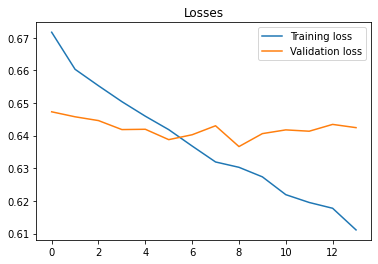

test model ...
k_fold: 1/5,	auc score: 0.675073375
train model ...
Epoch 0/49 Train loss: 0.67. Validation loss: 0.66. Elapsed time: 1.25.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 1/49 Train loss: 0.67. Validation loss: 0.65. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 2/49 Train loss: 0.66. Validation loss: 0.65. Elapsed time: 1.23.
Epoch 3/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 4/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 5/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 6/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.26.
Epoch 7/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.22.
Epoch 8/49 Train loss: 0.64. Validation loss: 0.64. Elapsed ti

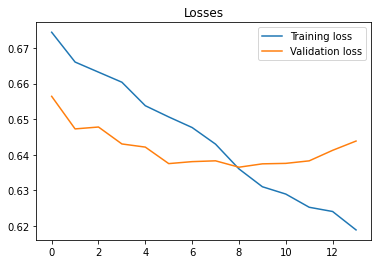

test model ...
k_fold: 2/5,	auc score: 0.6759537499999999
train model ...
Epoch 0/49 Train loss: 0.68. Validation loss: 0.65. Elapsed time: 1.25.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 1/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 2/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 3/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 4/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.23.
Epoch 5/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.23.
Epoch 6/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.22.
Epoch 7/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.22.
Epoch 8/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.23.
Earlystoppiong!


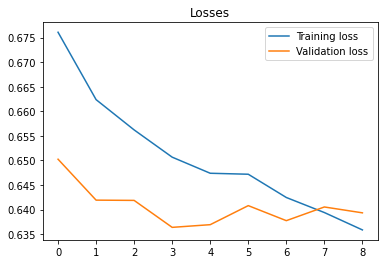

test model ...
k_fold: 3/5,	auc score: 0.6724579999999999
train model ...
Epoch 0/49 Train loss: 0.68. Validation loss: 0.66. Elapsed time: 1.25.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 1/49 Train loss: 0.67. Validation loss: 0.65. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 2/49 Train loss: 0.67. Validation loss: 0.65. Elapsed time: 1.25.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 3/49 Train loss: 0.66. Validation loss: 0.65. Elapsed time: 1.20.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 4/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 5/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.24.
Epoch 6/49 Train loss: 0.65. Validation loss: 0.65. Elapsed time: 1.23.
Epoch 7/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model.

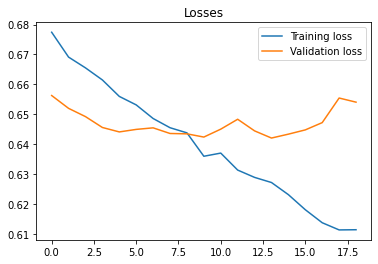

test model ...
k_fold: 4/5,	auc score: 0.6787866250000001
train model ...
Epoch 0/49 Train loss: 0.67. Validation loss: 0.65. Elapsed time: 1.25.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 1/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 2/49 Train loss: 0.66. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 3/49 Train loss: 0.65. Validation loss: 0.64. Elapsed time: 1.22.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 4/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.23.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 5/49 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.26.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 6/49 Train loss: 0.63. Validation loss: 0.63. Elapsed time: 1.26.
loss decresed {best_val_loss} -> {val_loss} save model...

Epoch 7/4

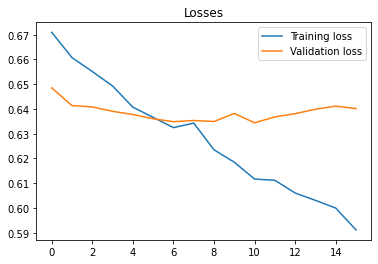

test model ...
k_fold: 5/5,	auc score: 0.6679247500000001
ratio_threshold: 0.9,	dist_type and dist_threshold: cosine_similarity 0.9
auc score: 0.6740392999999999, std: 0.0036649626452734817


[0.675073375,
 0.6759537499999999,
 0.6724579999999999,
 0.6787866250000001,
 0.6679247500000001]

In [9]:
main(ratio_threshold, preprocessing_function, dist_type, dist_threshold)